# SimCLR with Pytorch Lightning Applied to the Flowers Dataset

For more context, check the notebook in [simclr_pytorch_flowers](https://github.com/mxagar/simclr_pytorch_flowers); the present notebook is the result of porting the aforementioned repository to use **Pytorch Lightning**.

Table of contents:

TBD.

In [1]:
import os
import glob
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import (
    Dataset,
    DataLoader,
)

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomVerticalFlip,
    ColorJitter,
    RandomGrayscale,
    RandomApply,
    Compose,
    GaussianBlur,
    ToTensor,
    Normalize,
    CenterCrop,
    Resize
)
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR

import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import pandas as pd
import ast
import cv2

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA

import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.tuner.tuning import Tuner

# ensure reproducibility
pl.seed_everything(42, workers=True)

c:\Users\Msagardi\AppData\Local\anaconda3\envs\ds\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Global seed set to 42


42

## GPU Setup

In [2]:
torch.__version__
# '1.13.0+cu117'

'1.13.0+cu117'

In [3]:
# Get info of all GPU devices
!nvidia-smi

Sun Aug 13 18:02:38 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  | 00000000:22:00.0 Off |                  N/A |
|  0%   41C    P8              14W / 170W |     13MiB / 12288MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Set environment variable with possible device ids
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
print(os.environ["CUDA_VISIBLE_DEVICES"])
# Set device: 0 or 1
# NOTE: indices are not necessarily the ones shown by nvidia-smi
# We need to try them with the cell below
torch.cuda.set_device("cuda:0")

0,1


In [5]:
# Check that the selected device is the desired one
print("Torch version?", torch.__version__)
print("Torchvision version?", torchvision.__version__)
print("Is cuda available?", torch.cuda.is_available())
print("Is cuDNN version:", torch.backends.cudnn.version())
print("cuDNN enabled? ", torch.backends.cudnn.enabled)
print("Device count?", torch.cuda.device_count())
print("Current device?", torch.cuda.current_device())
print("Device name? ", torch.cuda.get_device_name(torch.cuda.current_device()))

Torch version? 1.13.0+cu117
Torchvision version? 0.14.0+cu117
Is cuda available? True
Is cuDNN version: 8500
cuDNN enabled?  True
Device count? 1
Current device? 0
Device name?  NVIDIA GeForce RTX 3060


## Config

In [73]:
class Config:
    def __init__(self):
        self.learning_rate = 0.001
        self.num_epochs = 200
        self.batch_size = 50 # 128
        self.patience = 30
        self.dropout_p = 0.3
        self.image_shape = [224, 224] # ResNet18
        self.kernel_size = [21, 21] # For the transforms, 10% of image size
        self.embedding_size = 128
        self.scheduler_step_size = 70
        self.scheduler_gamma = 0.1
        self.weight_decay = 1e-5
        self.max_norm = 1.0 # Gradient clipping
        self.temperature = 2.0
        self.backbone_model = "resnet50" # "resnet18", "resnet50"
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.output_path = "./output_flowers"

config = Config()

## Dataset and Stochastic Augmentation

In [74]:
def build_transform_pipeline(output_shape, kernel_size, s=1.0):
    """Build the image augmentation transform pipeline.
    
    Args:
        output_shape (list): model input shape
        kernel_size (list): kernel size for Gaussian blur
        s (float): Strength parameter; defaults to 1.0.
    
    Returns:
        image_transform (torchvision.transforms):
            Augmentation transform.
    """
    rnd_crop = RandomResizedCrop(output_shape)
    rnd_flip = RandomHorizontalFlip(p=0.5)

    # Use normalization iff we take a pre-trained ResNet or similar
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    normalize = Normalize(mean=imagenet_mean, std=imagenet_std)
    
    color_jitter = ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)
    rnd_color_jitter = RandomApply([color_jitter], p=0.8)
    
    rnd_gray = RandomGrayscale(p=0.2)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    rnd_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    to_tensor = ToTensor()
    image_transform = Compose([
        to_tensor,
        rnd_crop,
        #normalize, # use it if pretrained ResNet is taken
        rnd_flip,
        rnd_color_jitter,
        rnd_gray,
        rnd_gaussian_blur,
    ])
    
    return image_transform


class ContrastiveLearningViewGenerator(object):
    """Take an image (or a batch of images) and return
    n_views (2 by default) which are the result of applying
    the base_transform. That transform has random transformations
    which alter the images differently."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

In [75]:
class CustomDataset(Dataset):
    """Image dataset class."""

    def __init__(self, list_images, transform=None):
        """
        Args:
            list_images (list): List of all the images, 
                e.g., obtained with glob.
            transform (callable, optional): Optional transform to be applied
                on a sample/batch.
        """
        self.list_images = list_images
        self.transform = transform

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.list_images[idx]
        image = io.imread(img_name) # np.ndarray, RGB-image WxHxC
        if self.transform:
            image = self.transform(image) # CxWxH, transformed

        return image

In [76]:
def train_val_test_split(list_filenames, train_size=0.7, test_size=0.15):
    val_size = 1.0 - train_size - test_size

    num_images = len(list_filenames)
    num_train = int(num_images * train_size)
    num_val = int(num_images * val_size)

    list_filenames_train, list_filenames_non_train = train_test_split(list_filenames,
                                                                      train_size=num_train,
                                                                      shuffle=True,
                                                                      random_state=42)
    
    val_ratio = num_val / len(list_filenames_non_train)
    list_filenames_val, list_filenames_test = train_test_split(list_filenames_non_train,
                                                               train_size=val_ratio,
                                                               shuffle=True,
                                                               random_state=42)

    return list_filenames_train, list_filenames_val, list_filenames_test

list_images = glob.glob("./data/flowers/train/*/*.jpg")
list_images_train, list_images_val, list_images_test = train_val_test_split(list_images)

In [77]:
print("Total number of images: ", len(list_images))
print("Images in train split: ", len(list_images_train))
print("Images in validation split: ", len(list_images_val))
print("Images in test split: ", len(list_images_test))

Total number of images:  2746
Images in train split:  1922
Images in validation split:  411
Images in test split:  413


In [78]:
# Check there are no overlaps
len(set(list_images_train+list_images_val+list_images_test))

2746

In [79]:
# The size of the images
output_shape = config.image_shape # [224, 224]
kernel_size = config.kernel_size # [21, 21] # 10% of the output_shape

# The custom transform
base_transforms = build_transform_pipeline(output_shape=output_shape, kernel_size=kernel_size, s=1.0)
custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transforms)

image_ds_train = CustomDataset(
    #list_images=list_images,
    list_images=list_images_train,
    transform=custom_transform
)

image_ds_val = CustomDataset(
    list_images=list_images_val,
    transform=custom_transform
)

image_ds_test = CustomDataset(
    list_images=list_images_test,
    transform=custom_transform
)

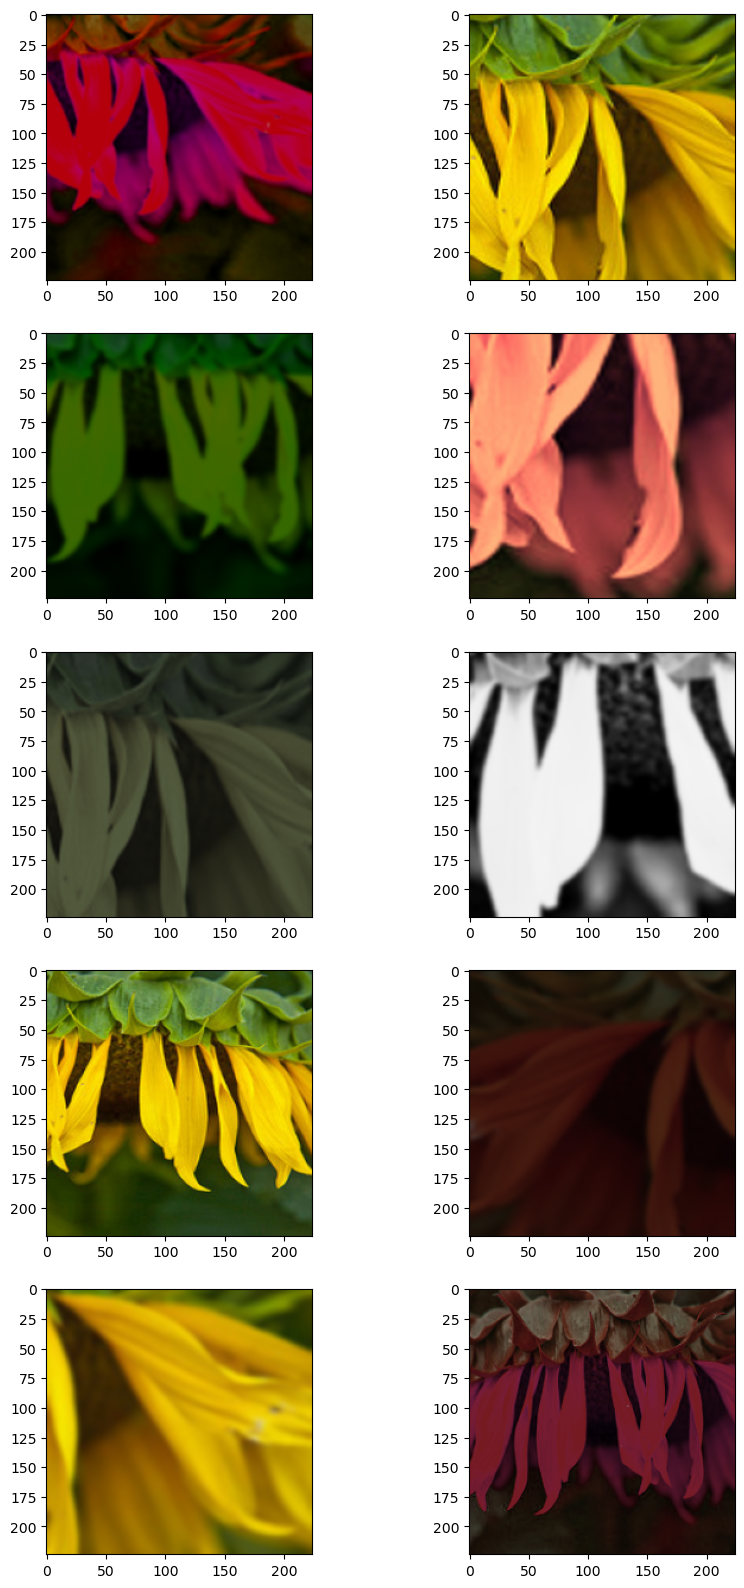

In [80]:
def view_data(image_ds, index):
    plt.figure(figsize=(10,20))
    for i in range(1,6):
        images = image_ds[index]
        view1, view2 = images
        plt.subplot(5,2,2*i-1)
        plt.imshow(view1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(view2.permute(1,2,0))

view_data(image_ds_train,200)

In [81]:
BATCH_SIZE = config.batch_size # 128 # 16 #128

# Building the data loader(s)
train_loader = torch.utils.data.DataLoader(
    image_ds_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    #num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

val_loader = torch.utils.data.DataLoader(
    image_ds_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    #num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

test_loader = torch.utils.data.DataLoader(
    image_ds_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    #num_workers=os.cpu_count(),
    drop_last=True,
    pin_memory=True,
)

In [82]:
print("Batches in TRAIN: ", len(train_loader))
print("Batches in VAL: ", len(val_loader))
print("Batches in TEST: ", len(test_loader))

Batches in TRAIN:  38
Batches in VAL:  8
Batches in TEST:  8


## SimCLR Model

In [83]:
class Identity(nn.Module):
    """Auxiliary identity mapping,
    i.e., it returns x = Indentity(x)."""
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

class SimCLR(nn.Module):
    """
    Basic SimCLR model with ResNet as backbone.
    The image is encoded with the ResNet of choice (ResNet18 or 50)
    and projected to embedding space.
    
    Parameters (with default values):
        dropout_p (float: 0.3): dropout for projection head.
        embedding_size (int: 128): latent embedding dimension.
        freeze (bool: False): whether backbone weights are frozen or not.
        linear_eval (bool: False): if True, we pass a batch of single views,
            i.e., for inference/projection, if False, we pass a batch of lists with
            two views, i.e., for training the model.
        backbone_model (str: "resnet18" | "resnet50"): encoding backbone model
            with pre-trained weights.
    """
    def __init__(self, dropout_p=0.3, embedding_size=128, freeze=False, linear_eval=False, backbone_model="resnet18"):
        super().__init__()
        self.linear_eval = linear_eval
        self.dropout_p = dropout_p
        self.embedding_size = embedding_size
        self.backbone_model = backbone_model
        
        backbone = Identity()
        backbone_out_features = 512
        if backbone_model == "resnet18":
            # (fc): Linear(in_features=512, out_features=1000, bias=True)
            backbone = models.resnet18(weights='ResNet18_Weights.DEFAULT') # pre-trained            
            backbone_out_features = 512
        elif backbone_model == "resnet50":
            # (fc): Linear(in_features=2048, out_features=1000, bias=True)
            backbone = models.resnet50(weights='ResNet50_Weights.DEFAULT') # pre-trained
            backbone_out_features = 2048
        # Replace fc classification head with Identity()
        backbone.fc = Identity()
        self.encoder = backbone
        
        if freeze:
            for param in self.encoder.parameters():
                param.requires_grad = False

        # hidden_size = 256, 512
        hidden_size = int(np.sqrt(backbone_out_features/self.embedding_size)) * self.embedding_size
        self.projection = nn.Sequential(
            nn.Linear(backbone_out_features, hidden_size), # (512, 256), (2048, 512)
            nn.Dropout(p=self.dropout_p),
            nn.ReLU(),
            nn.Linear(hidden_size, self.embedding_size) # (256, embedding_size), (512, embedding_size)
        )
        
    def forward(self, x):
        if not self.linear_eval:
            # We expect x to be a list of two views
            # We concatenate both views to be one large batch
            # of size 2*batch_size, i.e., (2*B, C, W, H) <- [(B, C, W, H), (B, C, W, H)]
            x = torch.cat(x, dim=0)
        
        encoding = self.encoder(x)
        encoding = encoding.view(encoding.size()[0], -1)
        # If not linear_eval: Projections: (2*B, E), they are concatenated
        # Else: (B, E)
        projection = self.projection(encoding) 
        
        return projection

In [84]:
#model = SimCLR()
#print(model)

## Lightning Modules

In [90]:
class LitSimCLR(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.criterion = nn.CrossEntropyLoss()
        
        # Unpack the hyperparameters
        self.learning_rate = config.learning_rate
        self.batch_size = config.batch_size
        self.max_epochs = config.num_epochs
        self.patience = config.patience
        self.dropout_p = config.dropout_p
        self.embedding_size = config.embedding_size
        self.scheduler_step_size = config.scheduler_step_size
        self.scheduler_gamma = config.scheduler_gamma
        self.weight_decay = config.weight_decay
        self.max_norm = config.max_norm
        self.temperature = config.temperature
        #self.device = config.device
        self.save_hyperparameters(ignore=["model", "criterion"])

    def contrastrive_loss(self, features):
        """NT-Xent (Normalized Temperature-Scaled Cross Entropy) Loss,
        aka. Contrastive Loss, used in the SimCLR paper.

        IMPORTANT NOTE: We don't really return the loss, but the logits
        and the (synthetic) labels to compute it with CrossEntropyLoss!

        The main idea behind SimCLR and contrastive learning is to learn
        representations that are close for positive pairs and far for negative pairs.
        In the case of SimCLR, a positive pair is two different augmentations
        of the same image, and a negative pair is two augmentations
        of two different images.

        How NT-Xent works:
        - Compute the cosine similarity between the representations
        of all pairs of images in the batch.
        - Apply a softmax to these similarities, but treat the similarity
        of each image with its positive pair as the correct class.
        This means that for each image, the goal is to make the
        softmax probability of its positive pair as high as possible,
        and the softmax probabilities of its negative pairs as low as possible.
        - Compute the cross entropy between these softmax probabilities
        and the true labels (which have a 1 for the positive pair
        and 0 for the negative pairs).
        - The temperature parameter scales the similarities before the softmax.
        A lower temperature makes the softmax output more peaky
        (i.e., the highest value will be much higher than the others,
        and the lower values will be closer to zero),
        while a higher temperature makes the softmax output more uniform.
        
        Args:
            projections: cat(z1, z2)
            z1: The projection of the first branch/view
            z2: The projeciton of the second branch/view
        
        Returns:
            the NTxent loss

        Notes on the shapes:
            inputs to model (views): [(B, C, W, H), (B, C, W, H)]
                B: batch size
                C: channels
                W: width
                H: height
                E: embedding size
            outputs from model (projections): [2*B, E]
            LABELS: [2*B, 2*B]
            features = outputs from model: [2*B, E]
            mask: [2*B, 2*B]
            similarity_matrix: [2*B, 2*B-1]
            positives: [2*B, 1]
            negatives: [2*B, 2*B-2]
            logits: [2*B, 2*B-1]
            labels: [2*B]
        """
        # FIXME: Refactor: take config out and pass necessary params, remove capital variables, etc.
        # FIXME: convert into class
        # FIXME: in Lightning we should not move objects .to(device), because that's handled automatically?
        BATCH_SIZE = self.batch_size
        DEVICE = self.device # self.config.device
        TEMPERATURE = self.temperature
        
        LABELS = torch.cat([torch.arange(BATCH_SIZE) for i in range(2)], dim=0)
        LABELS = (LABELS.unsqueeze(0) == LABELS.unsqueeze(1)).float() # Creates a one-hot with broadcasting
        LABELS = LABELS.to(DEVICE) # 2*B, 2*B

        similarity_matrix = torch.matmul(features, features.T) # 2*B, 2*B
        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(LABELS.shape[0], dtype=torch.bool).to(DEVICE)
        # ~mask is the negative of the mask
        # the view is required to bring the matrix back to shape
        labels = LABELS[~mask].view(LABELS.shape[0], -1) # 2*B, 2*B-1
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1) # 2*B, 2*B-1
        
        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1) # 2*B, 1

        # select only the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1) # 2*B, 2*B-2

        logits = torch.cat([positives, negatives], dim=1) # 2*B, 2*B-1
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(DEVICE)

        logits = logits / TEMPERATURE
        
        return logits, labels

    def forward(self, views):
        #projections = self.model([view.to(self.config.device) for view in views])
        projections = self.model(views)
        return projections
    
    def step(self, batch, batch_idx):
        views = batch
        projections = self(views)
        logits, labels = self.contrastrive_loss(projections)
        loss = self.criterion(logits, labels)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log("train_loss", loss) # tensorboard
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log("val_loss", loss) # tensorboard
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log("test_loss", loss) # tensorboard
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), # self.parameters()
                                     lr=self.learning_rate,
                                     weight_decay=self.weight_decay)
        lr_scheduler = StepLR(optimizer,
                              step_size=self.scheduler_step_size,
                              gamma=self.scheduler_gamma)        
        #return [optimizer], [lr_scheduler]
        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler,
            "monitor": "val_loss"
        }

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        # this calls forward
        # this will be used in trainer.predict(...)
        # we can make this step more sophisticated, if desired
        # NOTE: we can also avoid the forward() call
        # and implement any desired predict step here!
        self.model.linear_eval = True
        #outputs = self(batch[0])
        outputs = self(batch)
        self.model.linear_eval = False        
        return outputs
    
# init the autoencoder
model = SimCLR(dropout_p=config.dropout_p, embedding_size=config.embedding_size, backbone_model=config.backbone_model)
lit_simclr = LitSimCLR(model, config)

In [91]:
#from lightning.pytorch.callbacks.early_stopping import EarlyStopping

early_stop_callback = EarlyStopping(
    monitor="val_loss", # must be saved with self.log() in the LightningModule
    min_delta=0.00, # minimum change in the monitored quantity to qualify as an improvement
    patience=config.patience,
    verbose=False,
    mode="min" # or max if val_accuracy
)

In [92]:
#from lightning.pytorch.callbacks import ModelCheckpoint

# NOTE: if no ModelCheckpoint is specified, after each epoch the model checkpoint
# is saved in ./lightning_logs/version_X/checkpoints
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', # which metric to monitor
    dirpath=config.output_path,  # specify the path to save the checkpoints
    filename='best',  # best.ckpt - we can also use naming formats: {epoch}-{val_loss:.2f}
    save_last=True,  # ensures that the last epoch's model is saved: last.ckpt
    mode='min',  # save the model with the minimum 'val_loss'
)

## Training

In [95]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
# if GPU is available, we can invoke it with the accelerator flag
# the checkpoint and the logs are saved to lightining_logs/version_X
trainer = pl.Trainer(
    # OPTIONAL arguments
    #limit_train_batches=5,
    #limit_val_batches=2,
    #limit_test_batches=2,
    max_epochs=1, # config.num_epochs
    accelerator="gpu", # "mps" for Apple Silicon! Metal Performance Shaders
    devices=1, # in case we have several GPUs
    callbacks=[early_stop_callback, checkpoint_callback],
    log_every_n_steps=10,
    #precision="16-mixed",
    accumulate_grad_batches=4,
    gradient_clip_val=config.max_norm
    # if we want to disable saving / checkpointing
    # enable_checkpointing=False
    # if we want to control the directory where the checkpoint is saved
    # default_root_dir="some/path/"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [96]:
trainer.fit(
    model=lit_simclr,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
    # if we want to resume training where we left
    # ckpt_path="some/path/to/my_checkpoint.ckpt"
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SimCLR           | 24.6 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
98.491    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
